This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Modern convnet architecture patterns

### Modularity, hierarchy, and reuse

### Residual connections

**Residual block where the number of filters changes**

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

**Case where target block includes a max pooling layer**

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
residual = x
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [5]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_15[0][0]']              
                                                                                            

### Batch normalization

### Depthwise separable convolutions

### Putting it together: A mini Xception-like model

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manaswinipurumandla","key":"06efc8858e05861c43f63750a4bbda57"}'}

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c dogs-vs-cats

 97% 791M/812M [00:03<00:00, 304MB/s]
100% 812M/812M [00:03<00:00, 235MB/s]


In [9]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq test1.zip
!unzip -qq train.zip

# **Question 1**


Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation 
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce 
overfitting and improve performance in developing a network that you train from scratch. What 
performance did you achieve? 

In [10]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [13]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [14]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [15]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [16]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 15s 86ms/step - loss: 0.7632 - accuracy: 0.5085 - val_loss: 0.6920 - val_accuracy: 0.6210
Epoch 2/30
63/63 [==============================] - 5s 74ms/step - loss: 0.7026 - accuracy: 0.5035 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6993 - accuracy: 0.5410 - val_loss: 0.6849 - val_accuracy: 0.5650
Epoch 4/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6812 - accuracy: 0.6050 - val_loss: 0.6269 - val_accuracy: 0.6580
Epoch 5/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6368 - accuracy: 0.6510 - val_loss: 0.6311 - val_accuracy: 0.6360
Epoch 6/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6163 - accuracy: 0.6785 - val_loss: 0.6009 - val_accuracy: 0.6680
Epoch 7/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5686 - accuracy: 0.7055 - val_loss: 0.6539 - val_accuracy: 0.6400
Epoch 8/30
6

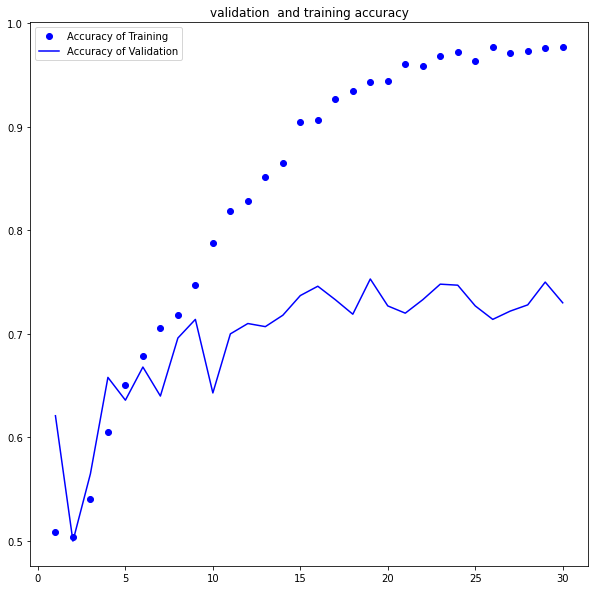

<Figure size 432x288 with 0 Axes>

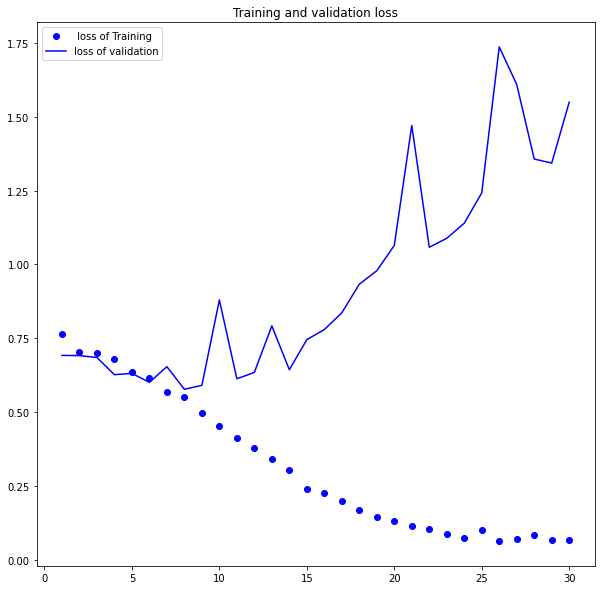

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Accuracy of Training")
plt.plot(epochs, val_accuracy, "b", label="Accuracy of Validation")
plt.title("validation  and training accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label=" loss of Training")
plt.plot(epochs, val_loss, "b", label="loss of validation")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 37ms/step - loss: 0.6092 - accuracy: 0.6710
Test accuracy: 0.671


#**Question2 **

Increase your training sample size. You may pick any amount. Keep the validation and test 
samples the same as above. Optimize your network (again training from scratch). What 
performance did you achieve?  

In [23]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [24]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

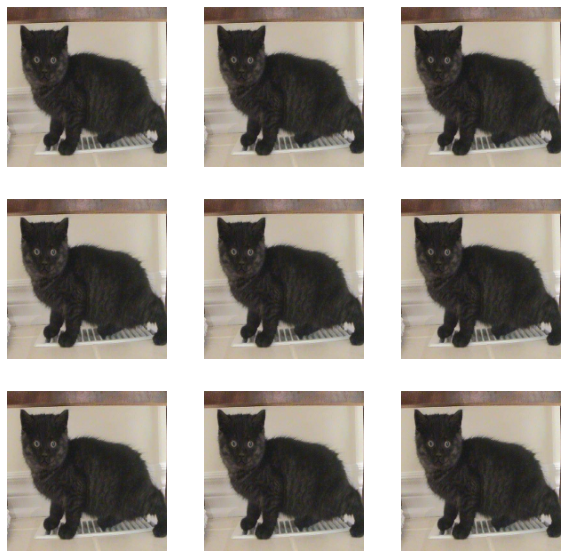

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 101ms/step - loss: 0.7218 - accuracy: 0.5095 - val_loss: 0.6916 - val_accuracy: 0.5010
Epoch 2/50
63/63 [==============================] - 6s 99ms/step - loss: 0.7148 - accuracy: 0.5250 - val_loss: 0.6832 - val_accuracy: 0.5780
Epoch 3/50
63/63 [==============================] - 7s 102ms/step - loss: 0.6908 - accuracy: 0.5795 - val_loss: 0.6903 - val_accuracy: 0.5520
Epoch 4/50
63/63 [==============================] - 7s 101ms/step - loss: 0.7057 - accuracy: 0.5800 - val_loss: 0.6583 - val_accuracy: 0.6320
Epoch 5/50
63/63 [==============================] - 8s 120ms/step - loss: 0.6568 - accuracy: 0.6295 - val_loss: 0.6488 - val_accuracy: 0.6020
Epoch 6/50
63/63 [==============================] - 7s 107ms/step - loss: 0.6455 - accuracy: 0.6500 - val_loss: 0.6123 - val_accuracy: 0.6650
Epoch 7/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6186 - accuracy: 0.6795 - val_loss: 0.5981 - val_accuracy: 0.6800
Epoch 8

In [28]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 41ms/step - loss: 0.4964 - accuracy: 0.8350
Test accuracy: 0.835


#**Question3**

Now change your training sample so that you achieve better performance than those from Steps 
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The 
objective is to find the ideal training sample size to get best prediction results.  

In [29]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [30]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 106ms/step - loss: 0.6956 - accuracy: 0.4850 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 7s 106ms/step - loss: 0.6933 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6933 - accuracy: 0.5060 - val_loss: 0.6925 - val_accuracy: 0.5790
Epoch 4/50
63/63 [==============================] - 8s 123ms/step - loss: 0.6945 - accuracy: 0.5125 - val_loss: 0.6921 - val_accuracy: 0.4960
Epoch 5/50
63/63 [==============================] - 7s 105ms/step - loss: 0.6928 - accuracy: 0.5110 - val_loss: 0.6903 - val_accuracy: 0.5400
Epoch 6/50
63/63 [==============================] - 7s 106ms/step - loss: 0.6905 - accuracy: 0.4960 - val_loss: 0.6823 - val_accuracy: 0.5500
Epoch 7/50
63/63 [==============================] - 7s 106ms/step - loss: 0.6949 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 

In [32]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 40ms/step - loss: 0.6861 - accuracy: 0.5530
Test accuracy: 0.553


#** Question4**

Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 
for the pretrained network may be the same or different from those using the network where 
you trained from scratch. Again, use any and all optimization techniques to get best 
performance.  

In [33]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [35]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [36]:
train_features.shape

(2000, 5, 5, 512)

In [37]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 21.3698 - accuracy: 0.9240 - val_loss: 5.6319 - val_accuracy: 0.9600
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 5.5114 - accuracy: 0.9705 - val_loss: 4.3573 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 2.2123 - accuracy: 0.9840 - val_loss: 4.4003 - val_accuracy: 0.9780
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.2997 - accuracy: 0.9900 - val_loss: 5.0495 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6722 - accuracy: 0.9930 - val_loss: 4.9590 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.2477 - accuracy: 0.9965 - val_loss: 3.8959 - val_accuracy: 0.9810
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.9275 - accuracy: 0.9925 - val_loss: 5.0197 - val_accuracy: 0.9790
Epoch 8/20
63/63 [

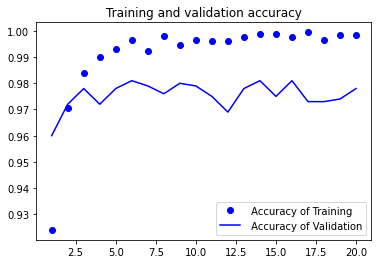

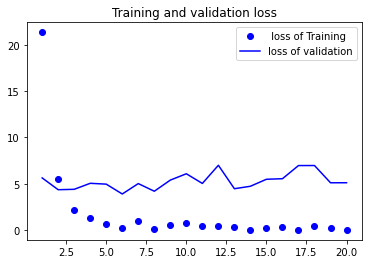

In [39]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label=" Accuracy of Training")
plt.plot(epochs, val_acc, "b", label=" Accuracy of Validation")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label=" loss of Training")
plt.plot(epochs, val_loss, "b", label="loss of validation")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [40]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [43]:
conv_base.trainable = True
print(" the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

 the number of trainable weights before freezing the conv base: 26


In [44]:
conv_base.trainable = False
print("The number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

The number of trainable weights after freezing the conv base: 0


In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 15s 206ms/step - loss: 14.1495 - accuracy: 0.9055 - val_loss: 4.0797 - val_accuracy: 0.9680
Epoch 2/50
63/63 [==============================] - 13s 202ms/step - loss: 7.8477 - accuracy: 0.9440 - val_loss: 13.0249 - val_accuracy: 0.9300
Epoch 3/50
63/63 [==============================] - 13s 206ms/step - loss: 7.9295 - accuracy: 0.9445 - val_loss: 3.5416 - val_accuracy: 0.9780
Epoch 4/50
63/63 [==============================] - 13s 209ms/step - loss: 5.1968 - accuracy: 0.9575 - val_loss: 3.1372 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 14s 210ms/step - loss: 3.5945 - accuracy: 0.9635 - val_loss: 7.3060 - val_accuracy: 0.9610
Epoch 6/50
63/63 [==============================] - 14s 212ms/step - loss: 2.5675 - accuracy: 0.9755 - val_loss: 6.5189 - val_accuracy: 0.9660
Epoch 7/50
63/63 [==============================] - 14s 211ms/step - loss: 3.5159 - accuracy: 0.9650 - val_loss: 4.1358 - val_accuracy: 0.97

In [47]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 114ms/step - loss: 1.7349 - accuracy: 0.9820
Test accuracy: 0.982


In [48]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [49]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [50]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 231ms/step - loss: 0.5587 - accuracy: 0.9875 - val_loss: 1.5830 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - 15s 231ms/step - loss: 0.3580 - accuracy: 0.9895 - val_loss: 2.3567 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 15s 237ms/step - loss: 0.5348 - accuracy: 0.9895 - val_loss: 2.3433 - val_accuracy: 0.9710
Epoch 4/30
63/63 [==============================] - 15s 238ms/step - loss: 0.2334 - accuracy: 0.9890 - val_loss: 1.5801 - val_accuracy: 0.9850
Epoch 5/30
63/63 [==============================] - 15s 229ms/step - loss: 0.1789 - accuracy: 0.9925 - val_loss: 1.8252 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 15s 233ms/step - loss: 0.3959 - accuracy: 0.9945 - val_loss: 1.6276 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 15s 235ms/step - loss: 0.2331 - accuracy: 0.9940 - val_loss: 1.4016 - val_accuracy: 0.9810

In [51]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 114ms/step - loss: 1.5654 - accuracy: 0.9780
Test accuracy: 0.978


# Summary
using the pre-trained model with out Augmentation

we find that the validation accuracy of about it indicates that we were able to achieve an improvement from the above when we started from the small scratch with the small model.and also when using pre-trained features,this isn't always the case. Despite employing a high rate of dropout ,the plots also show that we are overfitting nearly from the beginning.This is due to fact that this method does not employ data augmentation ,which is critical for avoiding overfitting with the tiny images data set. using the pre-trained model with augmentation The accuracy of a model is always determined by the collection of samples used to test it! some samples sets may be more challenging than others, and good results on one set may not necessarily apply to all others .Pretrained model was created as a result of it there was a small gain in accuracy with augmentation from 98% to - 99%

using pre-trained models with fine tuning we have a test accuracy of 97.5% in the case With the one point range accuracy ,the accuracy results may varry